In [1]:
# =================== IMPORTS =====================
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# ================ LOAD DATA =====================
df = pd.read_csv("Merged_data_final.csv")
df.drop(columns=['date'], inplace=True, errors='ignore')  # Optional in case 'date' exists
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df.dropna(subset=['Date'], inplace=True)
df.sort_values('Date', inplace=True)

# ================ FEATURE ENGINEERING =====================
def add_engineered_features(stock_df):
    stock_df = stock_df.copy()
    stock_df['EMA_12'] = stock_df['Close'].ewm(span=12, adjust=False).mean()
    stock_df['EMA_26'] = stock_df['Close'].ewm(span=26, adjust=False).mean()
    stock_df['MACD'] = stock_df['EMA_12'] - stock_df['EMA_26']
    stock_df['MACD_Signal'] = stock_df['MACD'].ewm(span=9, adjust=False).mean()

    delta = stock_df['Close'].diff()
    gain = delta.clip(lower=0).rolling(window=14).mean()
    loss = (-delta.clip(upper=0)).rolling(window=14).mean()
    rs = gain / loss
    stock_df['RSI_14'] = 100 - (100 / (1 + rs))

    stock_df['Lag_Close'] = stock_df['Close'].shift(1)
    stock_df['Price_Change_Pct'] = stock_df['Close'].pct_change()
    stock_df['Volatility_7d'] = stock_df['Close'].rolling(window=7).std()
    stock_df['Weekday'] = stock_df['Date'].dt.weekday

    return stock_df

df = df.groupby('Stock').apply(add_engineered_features).reset_index(drop=True)

# ================ ADD TREND LABEL =====================
df = df.dropna()
df['smoothed_close'] = df.groupby('Stock')['Close'].transform(lambda x: x.rolling(window=10).mean())
df['smoothed_return'] = df.groupby('Stock')['smoothed_close'].transform(lambda x: x.pct_change().shift(-1) * 100)
df['trend'] = (df['smoothed_return'] > 0).astype(int)

# ================ DEFINE FEATURES =====================
feature_cols = [
    'Open', 'High', 'Low', 'Close', 'Volume',
    'sentiment_mean', 'Price_Change_Pct', 'Volatility_7d',
    'EMA_12', 'EMA_26', 'MACD', 'MACD_Signal', 'RSI_14', 'Weekday'
]

df = df.dropna(subset=feature_cols + ['trend'])
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df[feature_cols])
y = df['trend'].values

# ================ SEQUENCE CREATION =====================
def create_sequences(X, y, seq_length=30):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X_scaled, y, seq_length=30)

# ================ TRAIN-TEST SPLIT =====================
split = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                        torch.tensor(y_train, dtype=torch.float32)), batch_size=64)

test_loader = DataLoader(TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                                       torch.tensor(y_test, dtype=torch.float32)), batch_size=64)

# ================ LSTM MODEL =====================
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.3)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return torch.sigmoid(self.fc(out)).squeeze()

# ================ TRAIN FUNCTION =====================
def train_model(model, train_loader, val_loader, epochs=10):
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            preds = model(X_batch)
            loss = criterion(preds, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")
    return model

# ================ EVALUATION FUNCTION =====================
def evaluate_model(model, test_loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            preds = model(X_batch)
            y_true.extend(y_batch.numpy())
            y_pred.extend((preds.numpy() > 0.5).astype(int))
    print("✅ Accuracy:", accuracy_score(y_true, y_pred))
    print("📊 Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("📋 Classification Report:\n", classification_report(y_true, y_pred))

# ================ TRAIN & EVALUATE =====================
model = LSTMClassifier(input_size=X_train.shape[2])
model = train_model(model, train_loader, test_loader, epochs=10)
evaluate_model(model, test_loader)

Epoch 1, Loss: 51.6795
Epoch 2, Loss: 50.8841
Epoch 3, Loss: 47.6931
Epoch 4, Loss: 43.2764
Epoch 5, Loss: 40.4171
Epoch 6, Loss: 38.9961
Epoch 7, Loss: 38.0927
Epoch 8, Loss: 37.0886
Epoch 9, Loss: 36.3649
Epoch 10, Loss: 35.6565
✅ Accuracy: 0.8126582278481013
📊 Confusion Matrix:
 [[474 105]
 [117 489]]
📋 Classification Report:
               precision    recall  f1-score   support

         0.0       0.80      0.82      0.81       579
         1.0       0.82      0.81      0.81       606

    accuracy                           0.81      1185
   macro avg       0.81      0.81      0.81      1185
weighted avg       0.81      0.81      0.81      1185



# Just Checking

In [1]:
# =================== IMPORTS =====================
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# =================== LOAD DATA =====================
df = pd.read_csv("Merged_data_final.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.dropna(subset=['Date'])
df.sort_values('Date', inplace=True)

# =================== DEFINE FEATURES =====================
features = [
    'sentiment_mean', 'Volume', 'sentiment_count',
    'Price_Change_Pct', 'Lag_Close', 'Volatility_7d', 'Weekday',
    'EMA_12', 'EMA_26', 'MACD', 'MACD_Signal', 'RSI_14'
]

df['Tomorrow_Close'] = df.groupby('Stock')['Close'].shift(-1)
df.dropna(subset=features + ['Tomorrow_Close'], inplace=True)

# =================== SEQUENCE CREATION =====================
def create_sequences(X, y, seq_len=30):
    Xs, ys = [], []
    for i in range(len(X) - seq_len):
        Xs.append(X[i:i+seq_len])
        ys.append(y[i+seq_len])
    return np.array(Xs), np.array(ys)

# =================== LSTM MODEL =====================
class LSTMRegressor(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size, 64, num_layers=2, batch_first=True, dropout=0.3)
        self.fc = nn.Linear(64, 1)

    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        return self.fc(hn[-1]).squeeze()

# =================== TRAIN AND EVALUATE PER STOCK =====================
stocks = df['Stock'].unique()
for stock in stocks:
    stock_df = df[df['Stock'] == stock].copy()

    # Scale features
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(stock_df[features])
    y = stock_df['Tomorrow_Close'].values

    X_seq, y_seq = create_sequences(X_scaled, y, seq_len=30)
    if len(X_seq) < 50:
        continue

    split = int(0.8 * len(X_seq))
    X_train, X_test = X_seq[:split], X_seq[split:]
    y_train, y_test = y_seq[:split], y_seq[split:]

    train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                            torch.tensor(y_train, dtype=torch.float32)), batch_size=32)
    test_loader = DataLoader(TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                                           torch.tensor(y_test, dtype=torch.float32)), batch_size=32)

    model = LSTMRegressor(input_size=X_train.shape[2])
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()

    for epoch in range(10):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = model(X_batch)
            loss = loss_fn(output, y_batch)
            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            pred = model(X_batch)
            predictions.extend(pred.numpy())
            actuals.extend(y_batch.numpy())

    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    print(f"\n📈 {stock} - RMSE: {rmse:.2f}")

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(actuals[-50:], label='Actual')
    plt.plot(predictions[-50:], label='Predicted')
    plt.title(f'{stock} - LSTM Prediction (Next Day Close)')
    plt.xlabel('Time Step')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.tight_layout()
    plt.grid(True)
    plt.show()


KeyError: ['Price_Change_Pct', 'Lag_Close', 'Volatility_7d', 'Weekday', 'EMA_12', 'EMA_26', 'MACD', 'MACD_Signal', 'RSI_14']


📊 AAPL - RMSE: 12.41


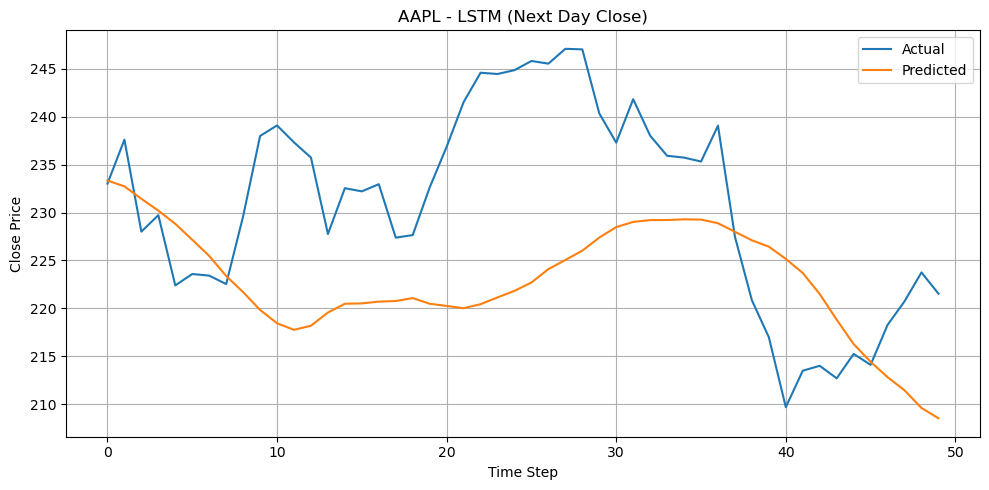


📊 AMZN - RMSE: 9.98


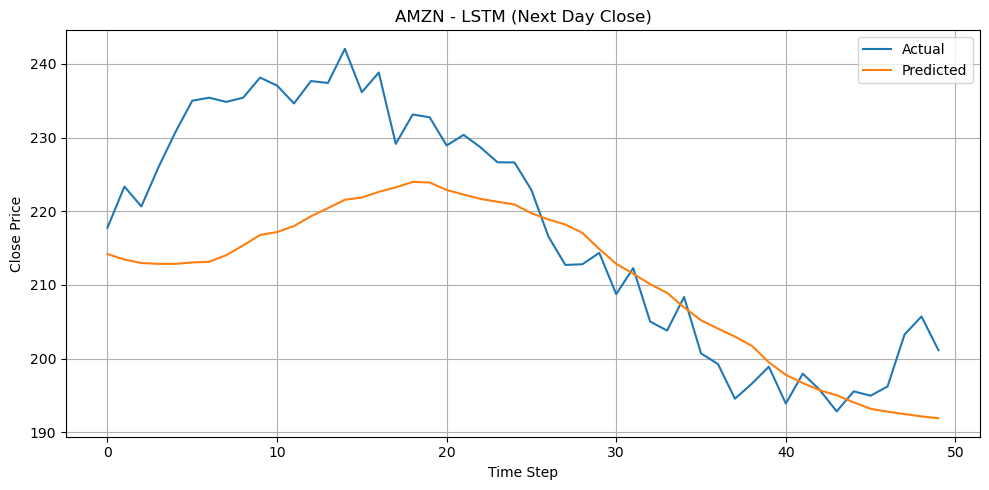


📊 GOOGL - RMSE: 7.50


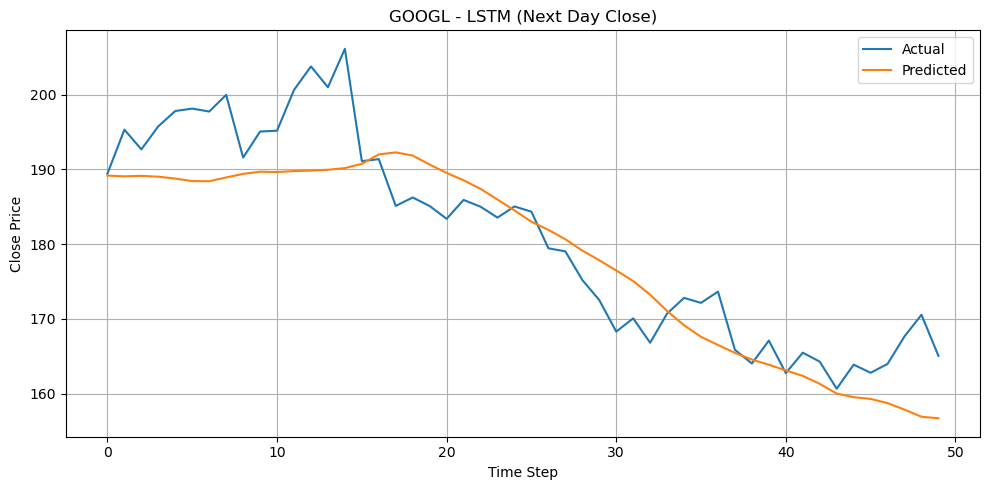


📊 META - RMSE: 40.94


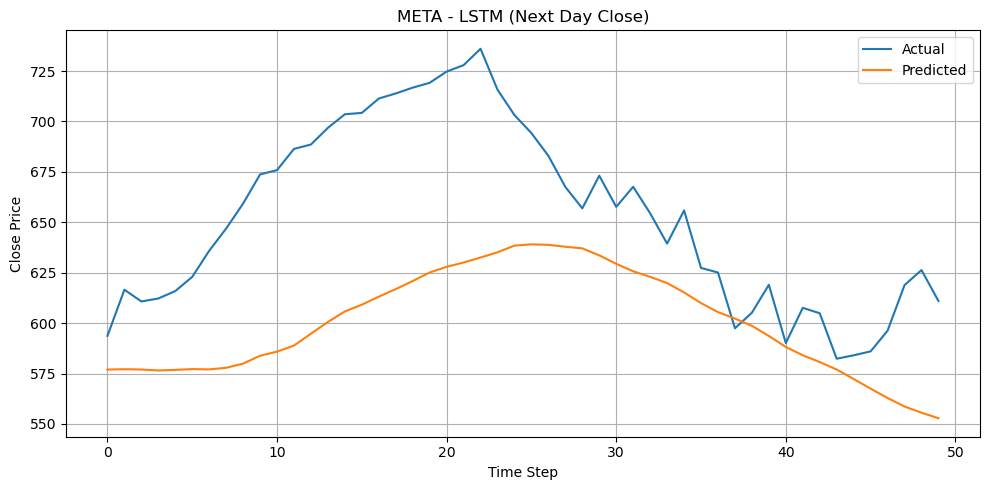


📊 MSFT - RMSE: 26.61


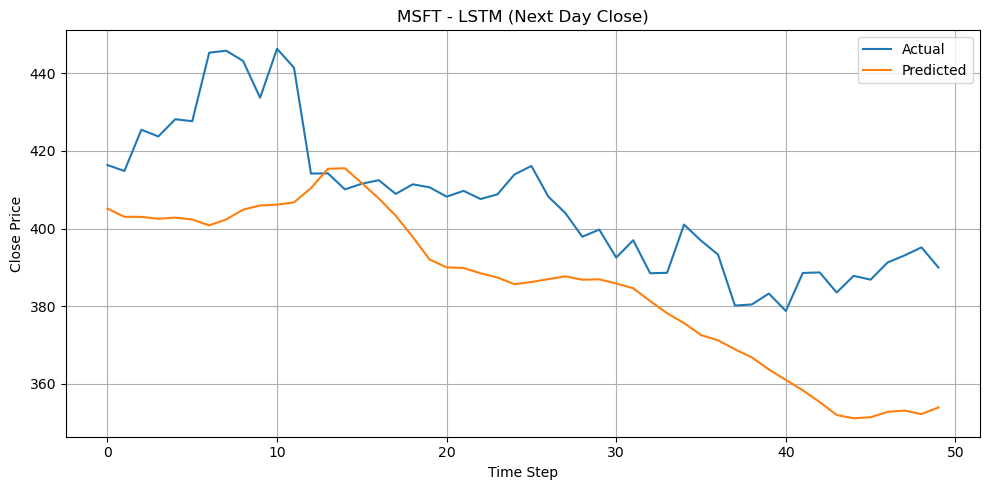


📊 NVDA - RMSE: 17.81


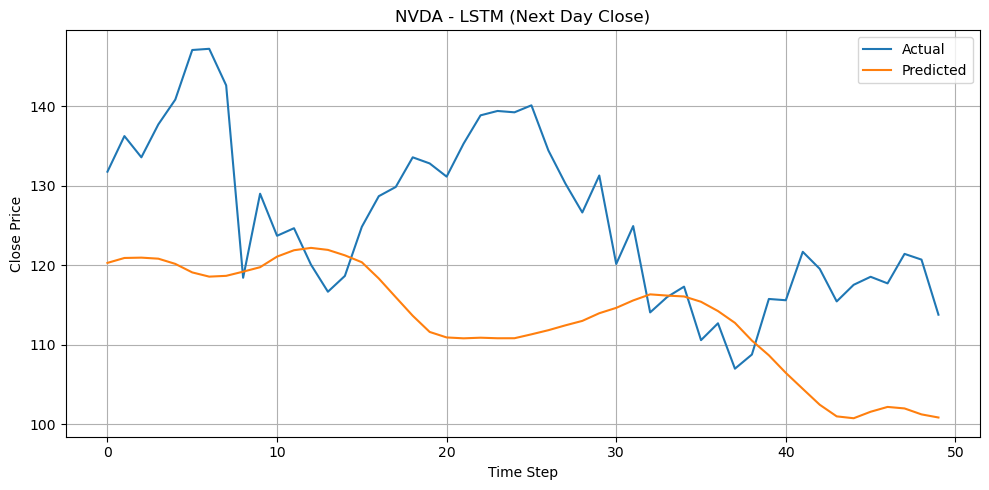


📊 TSLA - RMSE: 31.51


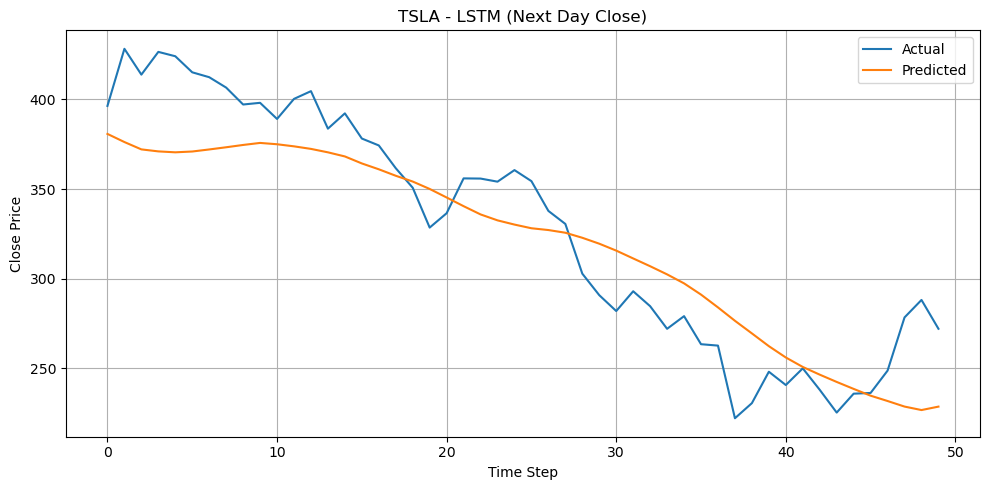

In [3]:
# =================== IMPORTS =====================
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# =================== LOAD DATA =====================
df = pd.read_csv("Merged_data_final.csv")
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df.dropna(subset=['Date'], inplace=True)
df.sort_values('Date', inplace=True)

# =================== FEATURE ENGINEERING =====================
def add_engineered_features(stock_df):
    stock_df = stock_df.copy()
    stock_df['EMA_12'] = stock_df['Close'].ewm(span=12, adjust=False).mean()
    stock_df['EMA_26'] = stock_df['Close'].ewm(span=26, adjust=False).mean()
    stock_df['MACD'] = stock_df['EMA_12'] - stock_df['EMA_26']
    stock_df['MACD_Signal'] = stock_df['MACD'].ewm(span=9, adjust=False).mean()
    delta = stock_df['Close'].diff()
    gain = delta.clip(lower=0).rolling(window=14).mean()
    loss = (-delta.clip(upper=0)).rolling(window=14).mean()
    rs = gain / loss
    stock_df['RSI_14'] = 100 - (100 / (1 + rs))
    stock_df['Lag_Close'] = stock_df['Close'].shift(1)
    stock_df['Price_Change_Pct'] = stock_df['Close'].pct_change()
    stock_df['Volatility_7d'] = stock_df['Close'].rolling(window=7).std()
    stock_df['Weekday'] = stock_df['Date'].dt.weekday
    return stock_df

df = df.groupby('Stock').apply(add_engineered_features).reset_index(drop=True)

# =================== DEFINE FEATURES & TARGET =====================
features = [
    'sentiment_mean', 'Volume', 'sentiment_count',
    'Price_Change_Pct', 'Lag_Close', 'Volatility_7d', 'Weekday',
    'EMA_12', 'EMA_26', 'MACD', 'MACD_Signal', 'RSI_14'
]
df['Tomorrow_Close'] = df.groupby('Stock')['Close'].shift(-1)
df.dropna(subset=features + ['Tomorrow_Close'], inplace=True)

# =================== SEQUENCE CREATION =====================
def create_sequences(X, y, seq_len=30):
    Xs, ys = [], []
    for i in range(len(X) - seq_len):
        Xs.append(X[i:i+seq_len])
        ys.append(y[i+seq_len])
    return np.array(Xs), np.array(ys)

# =================== LSTM MODEL =====================
class LSTMRegressor(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size, 64, num_layers=2, batch_first=True, dropout=0.3)
        self.fc = nn.Linear(64, 1)

    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        return self.fc(hn[-1]).squeeze()

# =================== TRAIN & EVALUATE PER STOCK =====================
stocks = df['Stock'].unique()
for stock in stocks:
    stock_df = df[df['Stock'] == stock].copy()

    # Scale features and target
    feature_scaler = MinMaxScaler()
    target_scaler = MinMaxScaler()

    X = stock_df[features].values
    y = stock_df[['Tomorrow_Close']].values

    X_scaled = feature_scaler.fit_transform(X)
    y_scaled = target_scaler.fit_transform(y).flatten()

    X_seq, y_seq = create_sequences(X_scaled, y_scaled, seq_len=30)
    if len(X_seq) < 50:
        print(f"⚠️ Not enough data for {stock}, skipping...")
        continue

    split = int(0.8 * len(X_seq))
    X_train, X_test = X_seq[:split], X_seq[split:]
    y_train, y_test = y_seq[:split], y_seq[split:]

    train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                            torch.tensor(y_train, dtype=torch.float32)), batch_size=32)
    test_loader = DataLoader(TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                                           torch.tensor(y_test, dtype=torch.float32)), batch_size=32)

    # Initialize model
    model = LSTMRegressor(input_size=X_train.shape[2])
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()

    # Train
    for epoch in range(10):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            preds = model(X_batch)
            loss = loss_fn(preds, y_batch)
            loss.backward()
            optimizer.step()

    # Predict
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            pred = model(X_batch)
            predictions.extend(pred.numpy())
            actuals.extend(y_batch.numpy())

    # Inverse transform predictions and targets
    pred_inv = target_scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
    actuals_inv = target_scaler.inverse_transform(np.array(actuals).reshape(-1, 1)).flatten()

    rmse = np.sqrt(mean_squared_error(actuals_inv, pred_inv))
    print(f"\n📊 {stock} - RMSE: {rmse:.2f}")

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(actuals_inv[-50:], label='Actual')
    plt.plot(pred_inv[-50:], label='Predicted')
    plt.title(f'{stock} - LSTM (Next Day Close)')
    plt.xlabel('Time Step')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


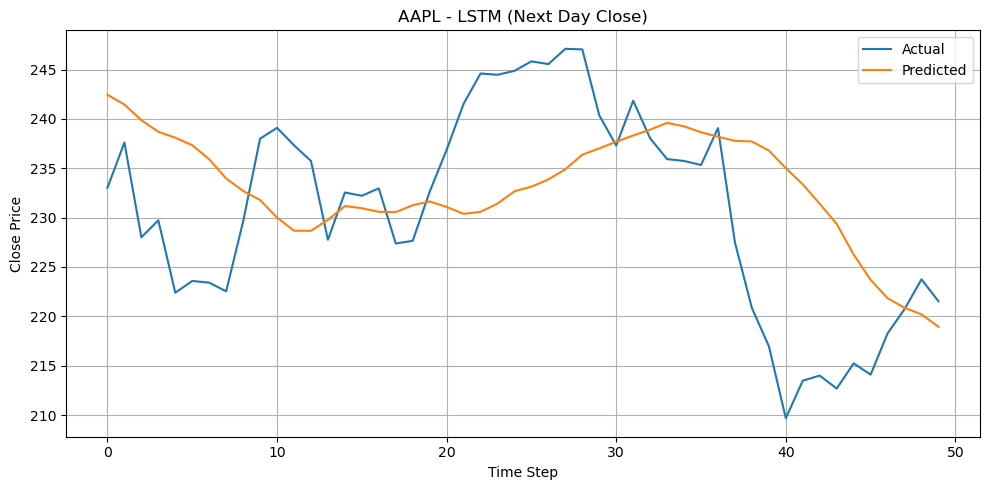

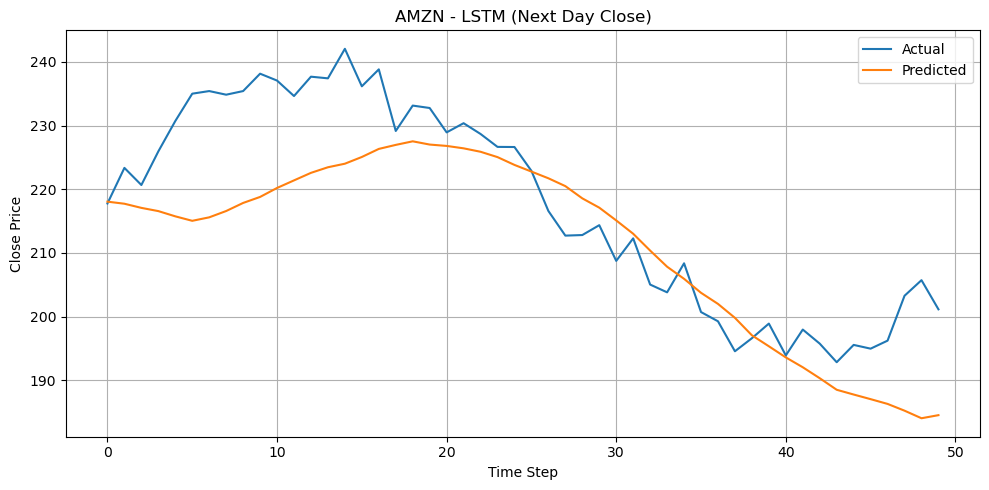

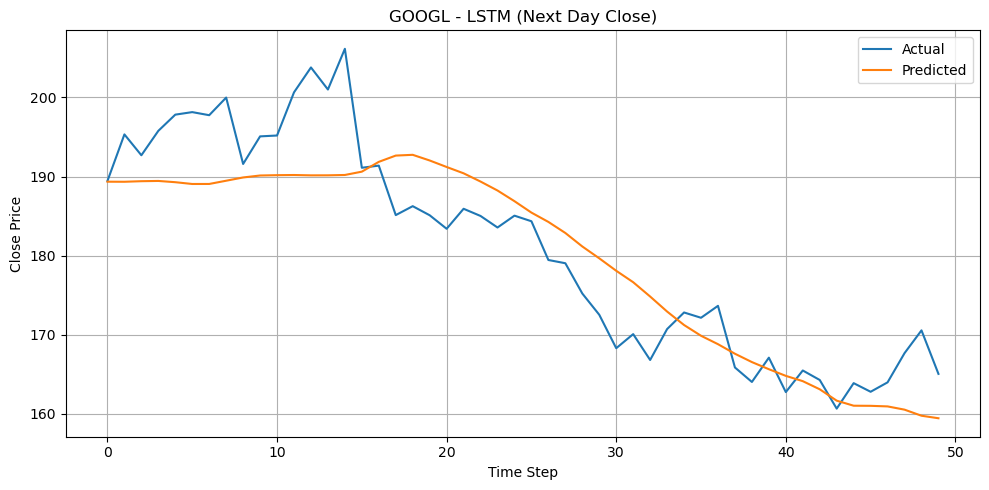

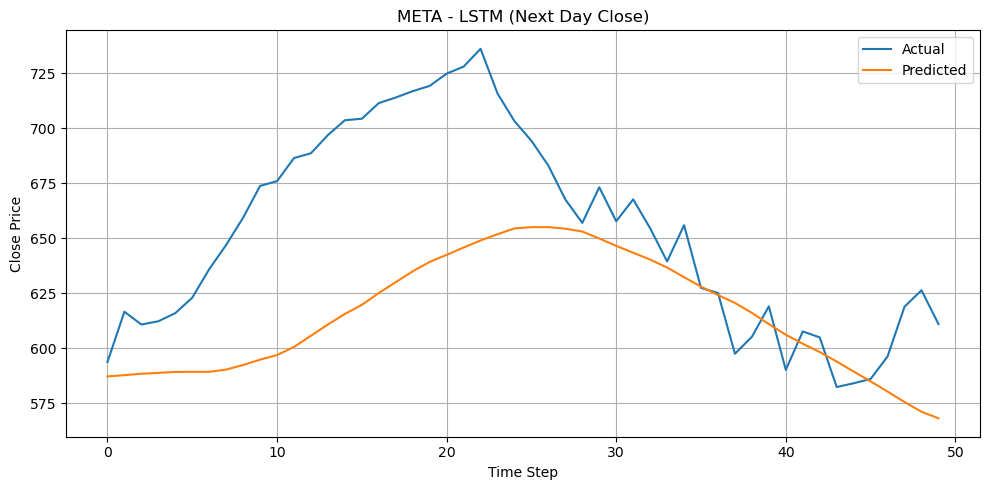

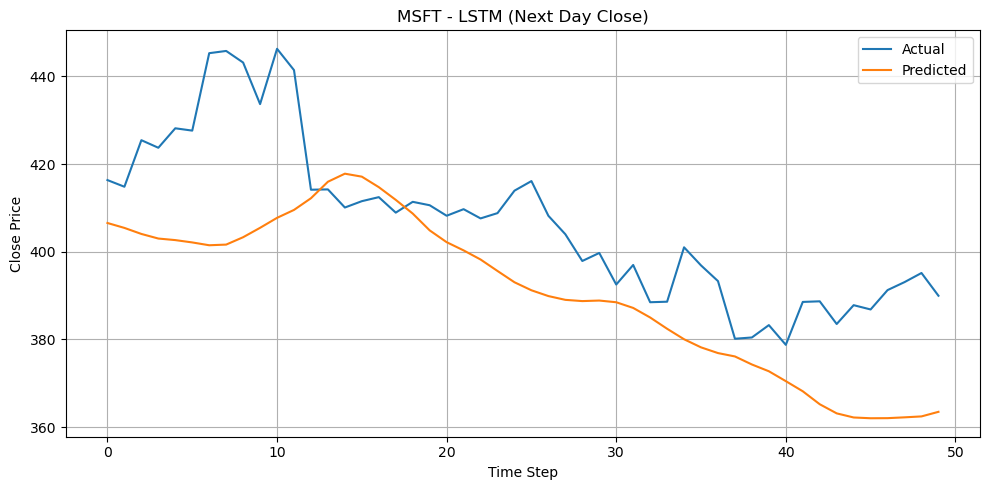

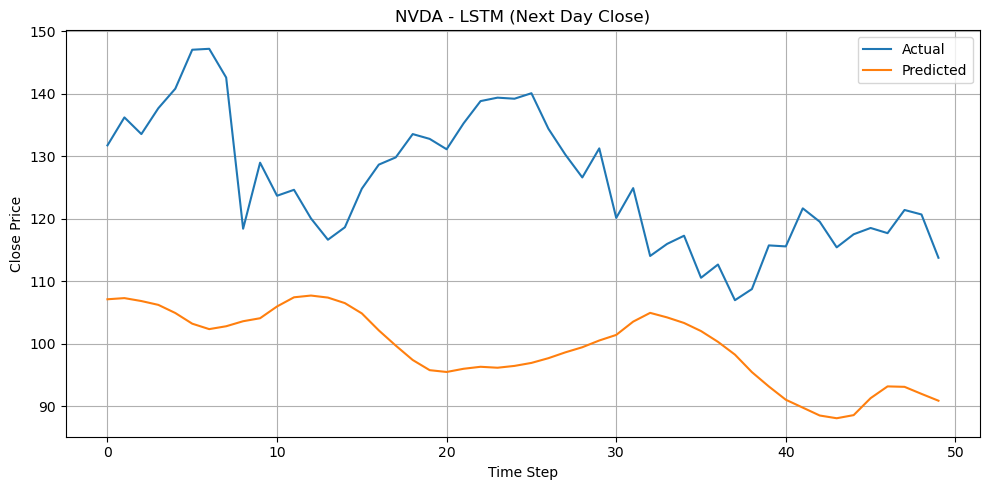

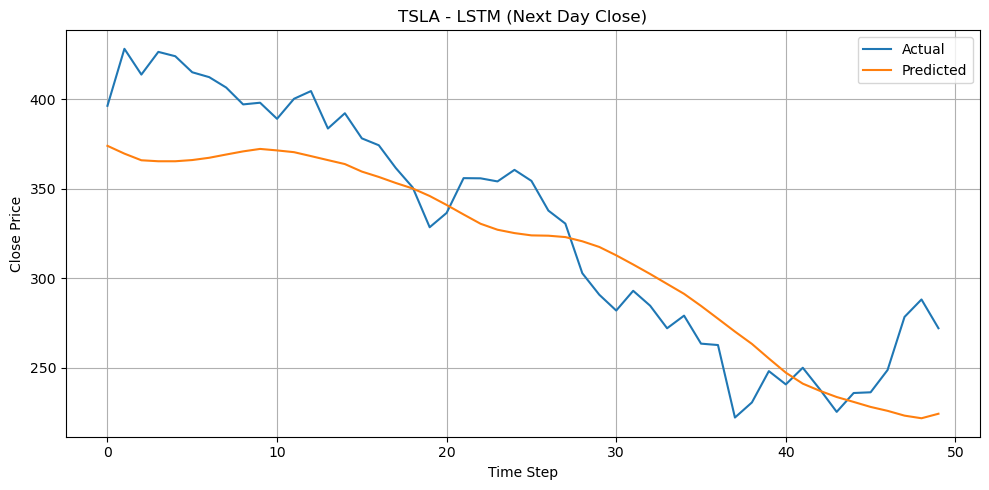


📊 Model Performance Summary:
🔹 AAPL → RMSE: 8.40999984741211, Direction Accuracy: 51.22%
🔹 AMZN → RMSE: 9.210000038146973, Direction Accuracy: 57.58%
🔹 GOOGL → RMSE: 6.96999979019165, Direction Accuracy: 52.44%
🔹 META → RMSE: 33.4900016784668, Direction Accuracy: 51.83%
🔹 MSFT → RMSE: 22.09000015258789, Direction Accuracy: 50.0%
🔹 NVDA → RMSE: 31.549999237060547, Direction Accuracy: 46.34%
🔹 TSLA → RMSE: 31.420000076293945, Direction Accuracy: 52.73%


In [4]:
# =================== IMPORTS =====================
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# =================== LOAD DATA =====================
df = pd.read_csv("Merged_data_final.csv")
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df.dropna(subset=['Date'], inplace=True)
df.sort_values('Date', inplace=True)

# =================== FEATURE ENGINEERING =====================
def add_engineered_features(stock_df):
    stock_df = stock_df.copy()
    stock_df['EMA_12'] = stock_df['Close'].ewm(span=12, adjust=False).mean()
    stock_df['EMA_26'] = stock_df['Close'].ewm(span=26, adjust=False).mean()
    stock_df['MACD'] = stock_df['EMA_12'] - stock_df['EMA_26']
    stock_df['MACD_Signal'] = stock_df['MACD'].ewm(span=9, adjust=False).mean()
    delta = stock_df['Close'].diff()
    gain = delta.clip(lower=0).rolling(window=14).mean()
    loss = (-delta.clip(upper=0)).rolling(window=14).mean()
    rs = gain / loss
    stock_df['RSI_14'] = 100 - (100 / (1 + rs))
    stock_df['Lag_Close'] = stock_df['Close'].shift(1)
    stock_df['Price_Change_Pct'] = stock_df['Close'].pct_change()
    stock_df['Volatility_7d'] = stock_df['Close'].rolling(window=7).std()
    stock_df['Weekday'] = stock_df['Date'].dt.weekday
    return stock_df

df = df.groupby('Stock').apply(add_engineered_features).reset_index(drop=True)

# =================== DEFINE FEATURES & TARGET =====================
features = [
    'sentiment_mean', 'Volume', 'sentiment_count',
    'Price_Change_Pct', 'Lag_Close', 'Volatility_7d', 'Weekday',
    'EMA_12', 'EMA_26', 'MACD', 'MACD_Signal', 'RSI_14'
]
df['Tomorrow_Close'] = df.groupby('Stock')['Close'].shift(-1)
df.dropna(subset=features + ['Tomorrow_Close'], inplace=True)

# =================== SEQUENCE CREATION =====================
def create_sequences(X, y, seq_len=30):
    Xs, ys = [], []
    for i in range(len(X) - seq_len):
        Xs.append(X[i:i+seq_len])
        ys.append(y[i+seq_len])
    return np.array(Xs), np.array(ys)

# =================== LSTM MODEL =====================
class LSTMRegressor(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size, 64, num_layers=2, batch_first=True, dropout=0.3)
        self.fc = nn.Linear(64, 1)

    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        return self.fc(hn[-1]).squeeze()

# =================== TRAIN & EVALUATE PER STOCK =====================
stocks = df['Stock'].unique()
summary = []

for stock in stocks:
    stock_df = df[df['Stock'] == stock].copy()

    # Scale features and target
    feature_scaler = MinMaxScaler()
    target_scaler = MinMaxScaler()

    X = stock_df[features].values
    y = stock_df[['Tomorrow_Close']].values
    today_close = stock_df['Close'].values

    X_scaled = feature_scaler.fit_transform(X)
    y_scaled = target_scaler.fit_transform(y).flatten()

    X_seq, y_seq = create_sequences(X_scaled, y_scaled, seq_len=30)
    if len(X_seq) < 50:
        print(f"⚠️ Not enough data for {stock}, skipping...")
        continue

    today_close_seq = today_close[30:30+len(y_seq)]  # Align with y_seq

    split = int(0.8 * len(X_seq))
    X_train, X_test = X_seq[:split], X_seq[split:]
    y_train, y_test = y_seq[:split], y_seq[split:]
    today_test = today_close_seq[split:]

    train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                            torch.tensor(y_train, dtype=torch.float32)), batch_size=32)
    test_loader = DataLoader(TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                                           torch.tensor(y_test, dtype=torch.float32)), batch_size=32)

    model = LSTMRegressor(input_size=X_train.shape[2])
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()

    # Train
    for epoch in range(10):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            preds = model(X_batch)
            loss = loss_fn(preds, y_batch)
            loss.backward()
            optimizer.step()

    # Predict
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            pred = model(X_batch)
            predictions.extend(pred.numpy())
            actuals.extend(y_batch.numpy())

    # Inverse transform predictions and targets
    pred_inv = target_scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
    actuals_inv = target_scaler.inverse_transform(np.array(actuals).reshape(-1, 1)).flatten()

    rmse = np.sqrt(mean_squared_error(actuals_inv, pred_inv))

    # Directional accuracy
    predicted_direction = np.where(pred_inv > today_test[-len(pred_inv):], "UP", "DOWN")
    actual_direction = np.where(actuals_inv > today_test[-len(actuals_inv):], "UP", "DOWN")
    direction_accuracy = np.mean(predicted_direction == actual_direction)

    summary.append({
        "Stock": stock,
        "RMSE": round(rmse, 2),
        "Direction Accuracy": round(direction_accuracy * 100, 2)
    })

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(actuals_inv[-50:], label='Actual')
    plt.plot(pred_inv[-50:], label='Predicted')
    plt.title(f'{stock} - LSTM (Next Day Close)')
    plt.xlabel('Time Step')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# =================== FINAL SUMMARY =====================
print("\n📊 Model Performance Summary:")
for item in summary:
    print(f"🔹 {item['Stock']} → RMSE: {item['RMSE']}, Direction Accuracy: {item['Direction Accuracy']}%")


In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from itertools import product

# ============ LOAD & PREPROCESS =============
df = pd.read_csv("Merged_data_final.csv")
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df.dropna(subset=['Date'], inplace=True)
df.sort_values('Date', inplace=True)

# ============ FEATURE ENGINEERING ===========
def add_engineered_features(stock_df):
    stock_df = stock_df.copy()
    stock_df['EMA_12'] = stock_df['Close'].ewm(span=12, adjust=False).mean()
    stock_df['EMA_26'] = stock_df['Close'].ewm(span=26, adjust=False).mean()
    stock_df['MACD'] = stock_df['EMA_12'] - stock_df['EMA_26']
    stock_df['MACD_Signal'] = stock_df['MACD'].ewm(span=9, adjust=False).mean()
    delta = stock_df['Close'].diff()
    gain = delta.clip(lower=0).rolling(window=14).mean()
    loss = (-delta.clip(upper=0)).rolling(window=14).mean()
    rs = gain / loss
    stock_df['RSI_14'] = 100 - (100 / (1 + rs))
    stock_df['Lag_Close'] = stock_df['Close'].shift(1)
    stock_df['Price_Change_Pct'] = stock_df['Close'].pct_change()
    stock_df['Volatility_7d'] = stock_df['Close'].rolling(window=7).std()
    stock_df['Weekday'] = stock_df['Date'].dt.weekday
    return stock_df

df = df.groupby('Stock').apply(add_engineered_features).reset_index(drop=True)

# ============ SETUP =============
features = [
    'sentiment_mean', 'Volume', 'sentiment_count',
    'Price_Change_Pct', 'Lag_Close', 'Volatility_7d', 'Weekday',
    'EMA_12', 'EMA_26', 'MACD', 'MACD_Signal', 'RSI_14'
]
df['Tomorrow_Close'] = df.groupby('Stock')['Close'].shift(-1)
df.dropna(subset=features + ['Tomorrow_Close'], inplace=True)

def create_sequences(X, y, seq_len=30):
    Xs, ys = [], []
    for i in range(len(X) - seq_len):
        Xs.append(X[i:i+seq_len])
        ys.append(y[i+seq_len])
    return np.array(Xs), np.array(ys)

# ============ LSTM CLASS ============
class LSTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers,
                            batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        return self.fc(hn[-1]).squeeze()

# ============ HYPERPARAMETER GRID ============
hidden_sizes = [32, 64, 128]
num_layers_list = [1, 2]
dropouts = [0.2, 0.3]

param_grid = list(product(hidden_sizes, num_layers_list, dropouts))

# ============ TUNING FOR ONE STOCK ============
stock = 'AAPL'
print(f"\n🔍 Tuning for stock: {stock}")

stock_df = df[df['Stock'] == stock].copy()
X = stock_df[features].values
y = stock_df[['Tomorrow_Close']].values
today_close = stock_df['Close'].values

feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

X_scaled = feature_scaler.fit_transform(X)
y_scaled = target_scaler.fit_transform(y).flatten()

X_seq, y_seq = create_sequences(X_scaled, y_scaled, seq_len=30)
today_close_seq = today_close[30:30+len(y_seq)]

split = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]
today_test = today_close_seq[split:]

train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                        torch.tensor(y_train, dtype=torch.float32)), batch_size=32)
test_loader = DataLoader(TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                                       torch.tensor(y_test, dtype=torch.float32)), batch_size=32)

results = []

# ============ GRID SEARCH ============
for hidden_size, num_layers, dropout in param_grid:
    model = LSTMRegressor(input_size=X_train.shape[2],
                          hidden_size=hidden_size,
                          num_layers=num_layers,
                          dropout=dropout)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()

    # Training
    for epoch in range(20):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            preds = model(X_batch)
            loss = loss_fn(preds, y_batch)
            loss.backward()
            optimizer.step()

    # Prediction
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            pred = model(X_batch)
            preds.extend(pred.numpy())
            trues.extend(y_batch.numpy())

    pred_inv = target_scaler.inverse_transform(np.array(preds).reshape(-1, 1)).flatten()
    actuals_inv = target_scaler.inverse_transform(np.array(trues).reshape(-1, 1)).flatten()
    rmse = np.sqrt(mean_squared_error(actuals_inv, pred_inv))

    predicted_dir = np.where(pred_inv > today_test[-len(pred_inv):], "UP", "DOWN")
    actual_dir = np.where(actuals_inv > today_test[-len(actuals_inv):], "UP", "DOWN")
    acc = np.mean(predicted_dir == actual_dir)

    results.append({
        "Hidden Size": hidden_size,
        "Layers": num_layers,
        "Dropout": dropout,
        "RMSE": round(rmse, 2),
        "Direction Accuracy": round(acc * 100, 2)
    })

# ============ OUTPUT TOP CONFIG ============
results_df = pd.DataFrame(results).sort_values(by='RMSE')
print("\n🏆 Top 5 Configurations by RMSE:")
print(results_df.head())

# Optionally save to Excel
# results_df.to_excel("lstm_tuning_results_AAPL.xlsx", index=False)



🔍 Tuning for stock: AAPL

🏆 Top 5 Configurations by RMSE:
    Hidden Size  Layers  Dropout  RMSE  Direction Accuracy
7            64       2      0.3  7.27               46.34
10          128       2      0.2  7.31               46.34
9           128       1      0.3  7.36               44.51
5            64       1      0.3  7.80               46.95
11          128       2      0.3  8.06               48.17
